In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys, time

from utils.data_utils import SAMPLING_FREQUENCY, load_data

import tensorflow as tf
from tensorflow import keras
from tcn import TCN

from custom.models import get_multi_output_model

## Prerequisites

Specify the directory where the data is stored.

In [2]:
ROOT_DIR = '/mnt/neurogeriatrics_data/MobiliseD_TVS/rawdata' if sys.platform == 'linux' else 'Z:\\MobiliseD_TVS\\rawdata'
WIN_LEN = int(10 * SAMPLING_FREQUENCY)  # corresponds to windows of 10 seconds

Get train and test data, where the proportion of test data is 20% of the subjects.

In [3]:
train_data, val_data, test_data = load_data(path=ROOT_DIR, win_len=WIN_LEN)

Split the train data into features and labels. For the labels, differentiate between labels for gait sequences and gait events.

In [4]:
X_train, y1_train, y2_train = train_data
y2_train = tf.keras.utils.to_categorical(y2_train, num_classes=5)
X_val, y1_val, y2_val = val_data
y2_val = tf.keras.utils.to_categorical(y2_val, num_classes=5)
print(f"Shape of train features: {X_train.shape}")
print(f"Shape of train labels: {y1_train.shape}")
print(f"Shape of train labels: {y2_train.shape}")
print(f"Shape of val features: {X_val.shape}")
print(f"Shape of val labels: {y1_val.shape}")
print(f"Shape of val labels: {y2_val.shape}")

Shape of train features: (50578, 640, 12)
Shape of train labels: (50578, 640, 1)
Shape of train labels: (50578, 640, 5)
Shape of val features: (22024, 640, 12)
Shape of val labels: (22024, 640, 1)
Shape of val labels: (22024, 640, 5)


Get a multi-output model that simultaneously classifies gait sequences as well as specific gait events.

In [5]:
model = get_multi_output_model(nb_channels=X_train.shape[-1], nb_classes = y2_train.shape[-1])
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "tcn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, 12)]   0                                            
____________________________________________________________________________________

Define callbacks to reduce the chance of overfitting.

In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience = 5,         # number of epochs in a row in which there is no improvement
        monitor = 'val_loss', # which performance metric to use
        mode = 'min'          # minimize or maximize the performance metric
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = './training/00',
        monitor = 'val_loss',
        save_best_only = True,
        save_weight_only = False,
        mode = 'min'
    )
]

In [8]:
history = model.fit(
    x = X_train,
    y = {'gait_sequences': y1_train,
         'gait_events': y2_train},
    batch_size = 32,
    epochs = 3,
    shuffle = True,
    validation_data = (X_val, {
        'gait_sequences': y1_val,
        'gait_events': y2_val
    }),
    callbacks = callbacks
)

Epoch 1/3


TypeError: 'NoneType' object is not callable

In [11]:
predictions = multi_output_model.predict(x=train_features)

In [15]:
for i in range(len(predictions)):
    print(type(predictions[i]))
    print(predictions[i].shape)

<class 'numpy.ndarray'>
(16592, 640, 1)
<class 'numpy.ndarray'>
(16592, 640, 5)


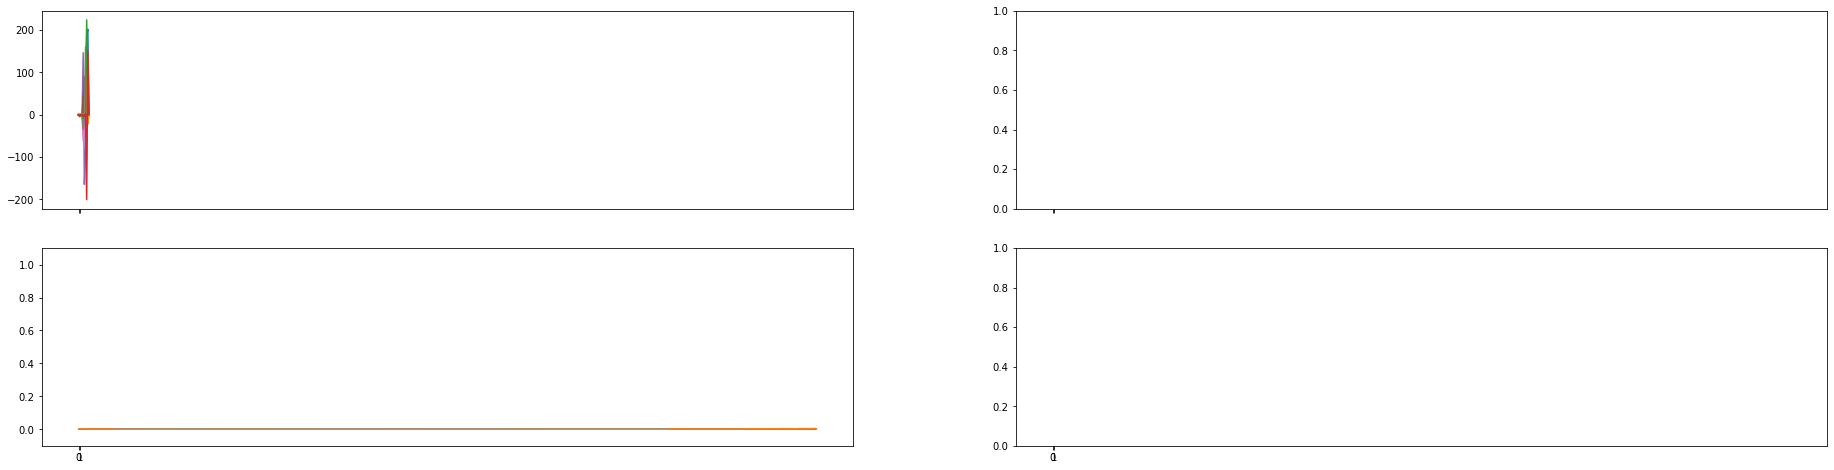

In [46]:
ix_random = np.random.choice(predictions[0].shape[0], 1, replace=False)[0]

fig, axs = plt.subplots(2, 2, figsize=(32, 8), sharex=True)
axs[0][0].plot(train_features[ix_random:ix_random+10][:,4])
axs[0][0].plot(train_features[ix_random:ix_random+10][:,10])
axs[1][0].plot(gait_labels[ix_random][:,0])
axs[1][0].plot(predictions[0][ix_random][:,0])
axs[1][0].set_ylim([-0.1, 1.1])
axs[1][0].set_xticks([0, 1])
plt.show()